# Unsupervised Clustering using a Mixture Model with PyMC3

This notebook will cover bayesian analysis techniques for use with mixture models. A mixture model is a probabilistic model that contains a number of subpopulations within a greater population. In this tutorial, we'll take a look at a mixture model with two subpopulations.

The following topics will be covered as PyMC3 is used to analyze the models:
> 1. Setting up a Pymc3 model.
> 2. Sampling the posterior distribution using Markov chain Monte Carlo (MCMC) and plotting the resulting traces.
> 3. Visualizing the posterior distributions of each parameter and variable.
> 4. Predicting the probability of new values belonging to a specific subpopulation.
> 5. Diagnosing MCMC convergence by looking at autocorrelation.
> 6. Calculating the HPD interval for reporting.

Code example found here is from Cameron Davidson-Pilon's book, Bayesian Methods for Hackers (available for as a book and for free online). Changes were added for learning purposes.

### Import modules

In [1]:
# import math
import numpy as np
import theano.tensor as T

# Stats
import scipy
from scipy import stats
import pymc3 as pm

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

### Generate two clusters of normal distributions
Sample data from these normal distributions with a set mean and standard deviation.

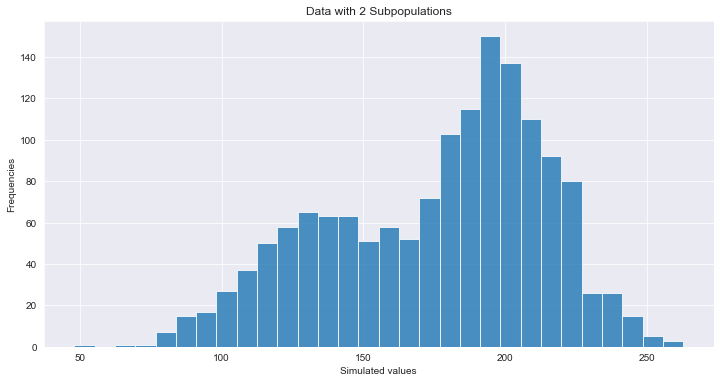

In [2]:
# Create seed for reproducible results
seed = 75005
np.random.seed(seed)

## Generate data from 2 normal distributions.
# The values here would otherwise be unknown to us if we were using real-world data.
mus = [130, 200]        # means
sigmas = [25, 20]       # standard deviations
ps = [0.35, 0.65]       # proportions
N = 1500                # total amount of data

data = np.hstack( [np.random.normal(mus[0], sigmas[0], int(ps[0]*N)),
                np.random.normal(mus[1], sigmas[1], int(ps[1]*N))] )

# Plot the histogram
fig = plt.figure(figsize=(12,6))
plt.hist(data, bins=30, alpha=0.8, edgecolor='white')
plt.xlabel('Simulated values')
plt.ylabel('Frequencies')
plt.title('Data with 2 Subpopulations')
plt.show()

### Assign data points to the two clusters

In [3]:
with pm.Model() as model:
    # When creating priors, build one that you think contains the true value
    p1 = pm.Uniform('p', 0, 1)     # Prior probability of data point being in cluster 0
    p2 = 1 - p1                    # Prior probability of data point being in cluster 1
    p = T.stack( [p1, p2] )        # Stack the two priors together
    
    assignment = pm.Categorical('assignment', p,
                                shape=N,
                                testval=np.random.randint(0, 2, N))    # Assign the N=1500 data points to clusters

print(f'prior assignment, with p = {p1.tag.test_value}')
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.5
[1 0 0 0 0 1 1 0 0 0]


### Create prior probabilities for each cluster's mean and standard deviation

In [4]:
with model:
    sds = pm.Uniform('sds', 0, 100, shape=2)       # flat prior used for the cluster standard deviations
    centers = pm.Normal('centers',
                        mu=np.array([130, 190]),
                        sd=np.array([10, 10]),
                        shape=2)                   # normal distribution priors used for cluster centers
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal('obs', mu=center_i, sd=sd_i, observed=data)    # how is this used in the model? it's not used in sampling
    
print(f"Random assignments: {assignment.tag.test_value[:4]}...")
print(f"Assigned center: {center_i.tag.test_value[:4]}...")
print(f"Assigned standard deviation: {sd_i.tag.test_value[:4]}")

Random assignments: [1 0 0 0]...
Assigned center: [190. 130. 130. 130.]...
Assigned standard deviation: [50. 50. 50. 50.]


We now have three types of priors indicating the prior probability of:
> 1. being assigned to a specific cluster
> 2. each cluster's center
> 3. each cluster's standard deviation

### MCMC sampling the posterior distribution (10,000 samples)
Traces are generated by following going through thousands of iterations, which are conducted by the 2 step functions: Metropolis and ElemwiseCategorical.

The MAP in the find_MAP function means _maximum a posterior_ (aka the peak of the posterior distribution). The traces need to start somewhere, and its starting position usually isn't the best position to start. Ideally, the best starting position would be at the peak of the posterior distribution, since the sampling algorithm doesn't have to spend much time finding where it is in the data space. However, it is discouraged in some scenarios. Please see: https://discourse.pymc.io/t/about-sampling-start-with-find-map/936

In [5]:
with model:
    # pm.find_MAP(fmin=scipy.optimize.fmin_powell)     # find the peak of the posterior distribution
    step1 = pm.Metropolis(vars=[p, sds, centers])      # Use metropolis for continuous variables
    step2 = pm.ElemwiseCategorical(vars=[assignment])  # Use ElemwiseCategorical for categorical variables
    trace = pm.sample(2500, step=[step1, step2])       # Using 2500 will result in 10000 due to 4 chains in 4 jobs

C:\Users\moogl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:48<00:00, 110.38draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


### Plot the traces for the centers and standard deviations of both clusters, and the probability of cluster 0
The trace plots the variables' path during sampling.

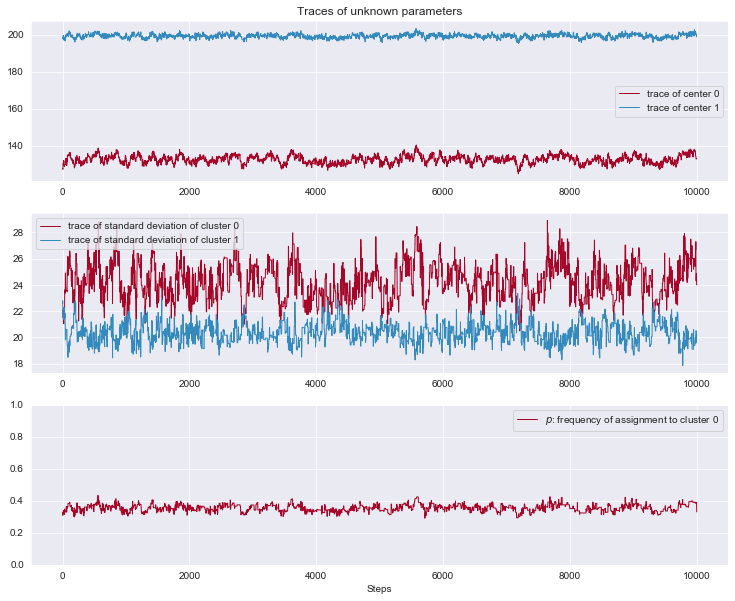

In [6]:
fig = plt.figure(figsize=(12.5, 10))

plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend()

### MCMC sampling the posterior distribution (additional 30,000 samples)
The trace object returns coverges to a distribution of possible points. We can continue where we left off and sample an additional 30,000 samples using our same trace object without overwriting the first 10,000 samples using the code below:

In [7]:
with model:
    #pm.find_MAP(fmin=scipy.optimize.fmin_powell)          # find the peak of the posterior distribution
    trace = pm.sample(7500, step=[step1, step2], trace=trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
Sampling 4 chains: 100%|██████████| 32000/32000 [05:04<00:00, 105.01draws/s]
The number of effective samples is smaller than 10% for some parameters.


### Plot the traces with the additional 20,000 samples
The first few thousands of samples are usually not accurate since the algorithm hasn't had enough samples to converge. This is why we will sample more data on top of the samples we already have.

See Bayesian Methods for Hackers Chapter 3 notes on MCMC sampling:

> 1.   The traces converges, not to a single point, but to a distribution of possible points. This is convergence in an MCMC algorithm.

> 2.   Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the burn-in period.

> 3.   The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well. This will be detailed in the Diagnostics section later in this chapter.

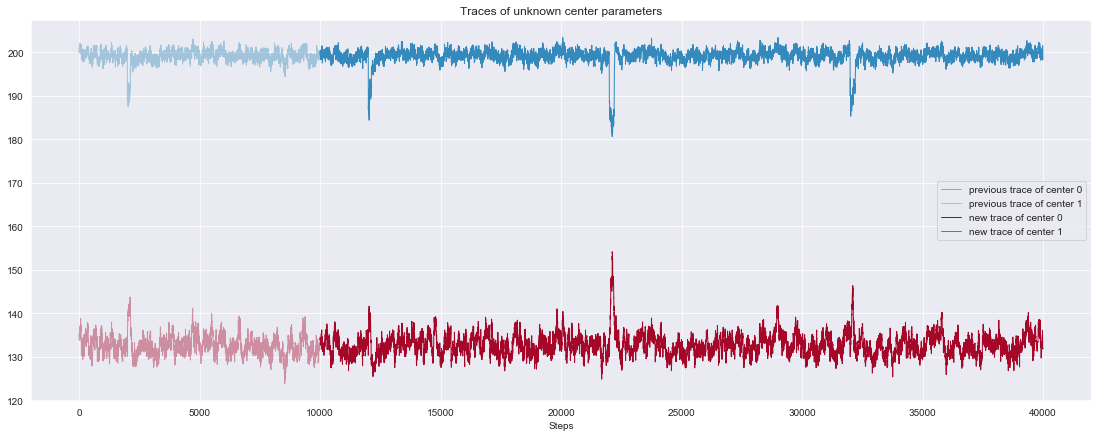

In [8]:
fig = plt.figure(figsize=(19, 7))
sns.set_style('darkgrid')

center_trace = trace["centers"][10000:]
prev_center_trace = trace["centers"][:10000]

x = np.arange(10000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[0])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[1])

x = np.arange(10000, 40000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#A60628")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#348ABD")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

### Analyzing the trace samples

In [9]:
print(f'The mean of the trace of center 0 is {round(center_trace[:, 0].mean(), 2)}. The true value is {mus[0]}.')
print(f'The mean of the trace of center 1 is {round(center_trace[:, 1].mean(), 2)}. The true value is {mus[1]}.')

The mean of the trace of center 0 is 132.78. The true value is 130.
The mean of the trace of center 1 is 199.07. The true value is 200.


The posterior traces for the means of the two subpopulations in the mixture model appear to be fairly accurate. The same can be seen for the standard deviations as well below:

In [10]:
print(f'The mean trace of sd 0 is {round(std_trace[:, 0].mean(), 2)}. The true value is {sigmas[0]}.')
print(f'The mean trace of sd 1 is {round(std_trace[:, 1].mean(), 2)}. The true value is {sigmas[1]}.')

The mean trace of sd 0 is 24.21. The true value is 25.
The mean trace of sd 1 is 20.37. The true value is 20.


### Investigating the posterior distributions of the clusters
The posterior distributions for the means and standard deviations for each cluster is plotted below.

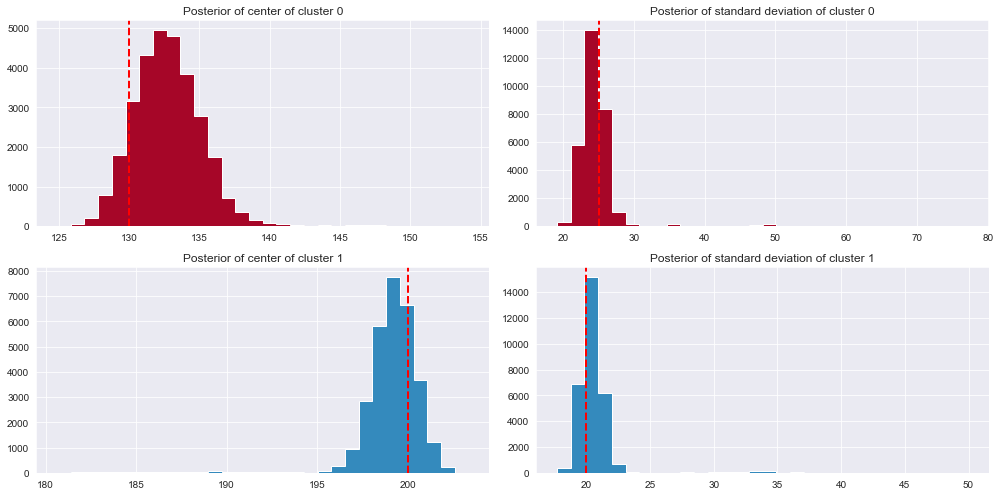

In [11]:
fig = plt.figure(figsize=(14, 7))

center_true = [130, 200]
sd_true = [25, 20]

std_trace = trace["sds"][10000:]
prev_std_trace = trace["sds"][:10000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title(f"Posterior of center of cluster {i}")
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    plt.axvline(x=center_true[i], color='r', linestyle='dashed', linewidth=2)

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title(f"Posterior of standard deviation of cluster {i}")
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    plt.axvline(x=sd_true[i], color='r', linestyle='dashed', linewidth=2)

    # plt.autoscale(tight=True)

plt.tight_layout()

The posterior distributions for each center seem to center around 132 and 190 for center 0 and center 1 respectively. For the standard deviation it's around 24 and 21 respectively. The true values for each variable is plotted with a vertical line.

### Investigate the posterior distribution of the data point labels

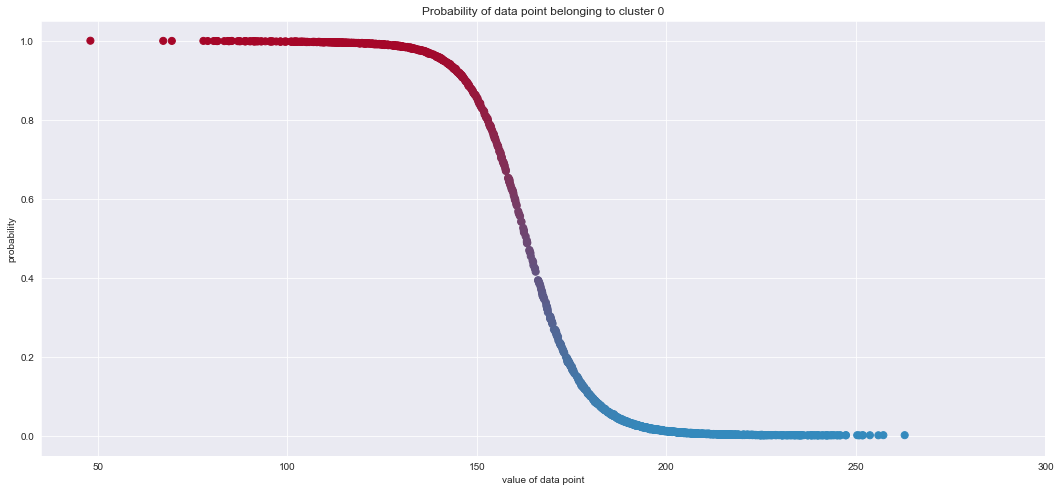

In [12]:
fig = plt.figure(figsize=(18, 8))

cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)      # mpl = matplotlib
assign_trace = trace["assignment"]     # Holds the 40,000 samples of sets of 1500 data points assigned to clusters

plt.scatter(data, 1 - assign_trace.mean(axis=0),
            cmap=cmap,
            c=assign_trace.mean(axis=0), # calculates the mean of the N=1500 data points for each of the 40,000 samples
            s=50)

plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

It makes sense that as the value of the data point decreases, the probability of it being assigned to the cluster with the lower center value (cluster 0) also increases. The opposite is true too—as the value of the data point increases, the higher probability for the data point to be classified as to be from cluster 1 increases.

### Plotting a fitted posterior distribution for each cluster
These fits are not the best, but it works!

C:\Users\moogl\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


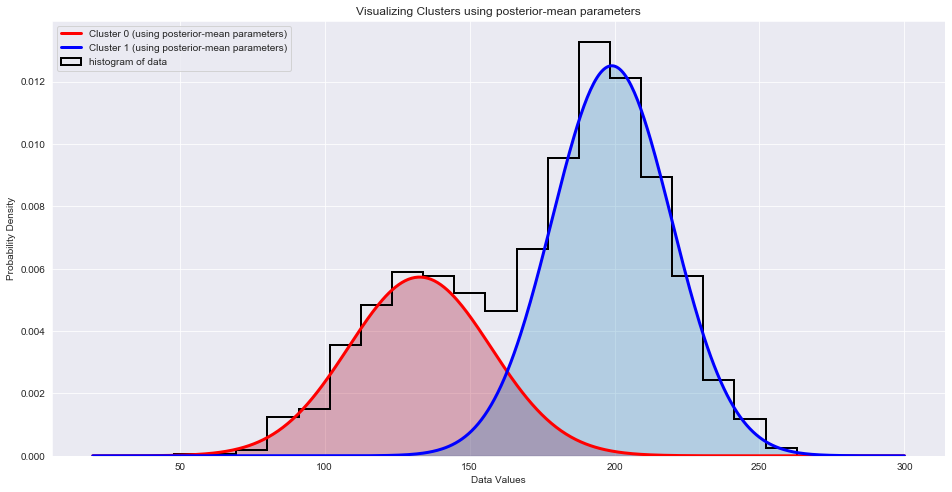

In [13]:
fig = plt.figure(figsize=(16, 8))

norm = stats.norm
x = np.linspace(20, 300, 500)

posterior_center_means = center_trace.mean(axis=0)      # axis=0 calculates mean along the 40,000 rows (samples)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()                    # Posterior prob mean of cluster 0.

# Plot histogram of the original data
plt.hist(data,
         bins=20,
         histtype="step",
         normed=True,
         color="k",
         lw=2,
         label="histogram of data")

## Plot cluster 0's fitted posterior distribution
# The norm distribution sets where the center of the distribution is and its standard deviation
# posterior_p_mean scales the norm distribution to the correct probabilities
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0], scale=posterior_std_means[0])

plt.plot(x, y,
         label="Cluster 0 (using posterior-mean parameters)",
         lw=3,
         color='red')

plt.fill_between(x, y,
                 color=colors[0],
                 alpha=0.3)

## Plot cluster 1's fitted posterior distribution
# (1 - posterior_p_mean) is the conjugate of the posterior_p_mean. This is the posterior prob mean of cluster 1.
y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1], scale=posterior_std_means[1])

plt.plot(x, y,
         label="Cluster 1 (using posterior-mean parameters)",
         lw=3,
         color='blue')

plt.fill_between(x, y,
                 color=colors[1],
                 alpha=0.3)

plt.xlabel('Data Values')
plt.ylabel('Probability Density')
plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

### Using our model to predict where new data points belong to which cluster
Rather than assigning the data point that is closest to the center of a specific cluster, we will use probability to determine where that data point is going. There are a couple of ways to do this:

> 1. Add the data point to the original data and run MCMC again. Use trace["assignment"].mean(axis=0) to visualize on a scatterplot where the value of your data point lies and to determine its probability of being in a specific cluster. Please see the cell titled: __Investigate the posterior distribution of the data point labels__ to see an example of this. This method takes longer to do, but more precise.

> 2. Use Bayes Theorem to calculate the probability of the data point being in a specific cluster. This is the faster method, but is less accurate.

For an example of method 2, let's say that we have a new data point $x$ with a value of 150. We'd like to know the probability of this data point being in cluster 0.

### Recall Bayes Theorem:

\begin{equation*}
P(A|X) = \frac{P(X|A)P(A)}{P(X)}
\end{equation*}

$P(A)$: Probability of being in cluster 0 (aka the prior probability). This can also be cluster 1 depending on how you set this up.

$P(X)$: Probability of the data having a value $x$ of 150. This can be any number that you want to predict. This can be tricky to calculate, but the math shown later can cancel this value out.

$P(A|X)$: Probability of A given that X occured (aka the posterior probability).

$P(X|A)$: Probability of X given that A occured.

### Setting up the equation

Let's first specify the assignment of x to a cluster as the variable $L_z$, which can be 0 or 1. We ask the following question to help us out with setting up the math: "What is the probability of our value $x$ = 160 being in cluster 0 __greater__ than $x$ being in cluster 1?"

We can then set up the following equation:

\begin{equation*}
P(L_z=0|x=160) > P(L_x=1|x=160)
\tag{1}
\end{equation*}

\begin{equation*}
\frac{P(x=160|L_z=0)P(L_x=0)}{P(x=160)} > \frac{P(x=160|L_z=1)P(L_x=1)}{P(x=160)}
\tag{2}
\end{equation*}

We can cancel out $P(x=160)$ from both denominators, making the math much easier to calculate:

\begin{equation*}
P(x=160|L_z=0)P(L_x=0) > P(x=160|L_z=1)P(L_x=1)
\tag{3}
\end{equation*}

### Making the prediction

In [14]:
norm_pdf = stats.norm.pdf

# Trace object denoting samples from the posterior distribution of probabilities of cluster 0 assignement
p_trace = trace["p"][10000:]
prev_p_trace = trace["p"][:10000]

# The new data point to predict
x = 160

# Counts the proportion of values from cluster 0 that are greater than values from cluster 1.
v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print(f'Probability of belonging to cluster 0: {round(v.mean(), 3)*100}%')

Probability of belonging to cluster 0: 86.4%


It appears that the model is highly confident that $x$ = 150 belongs to the first cluster. Try setting the value of x to different numbers and see how that affects the prediction!

### Analyzing MCMC convergence by looking at autocorrelation
Autocorrelation is a metric between -1 and 1 that measures how related is the data to itself. This is done by comparing the correlation of the data with a time-lagged version of the same data. When data is highly autocorrelated, we can predict with relative ease the value right before or after. For data that is not autocorrelated, it is much harder to predict because there is no inherent pattern to the data.

Where $x$ is data and $t$ is a specific index or time period. $t-k$ represents the time or index $k$ units behind $t$.

Cam Davidson-Pilon provides an example illustrated in his book. He posits two time-series data:

\begin{equation*}
x_t : Normal(0,1), x_0 = 0
\end{equation*}

\begin{equation*}
y_t : Normal(y_t-1,1), x_0 = 0
\end{equation*}

The graph that generates these equations is below:

In [ ]:
# set figure size
fig = plt.figure(figsize=(12.5, 4))

# set random seed for reproducible results
np.random.seed(seed)

# Draw random samples from a normal distribution
x_t = np.random.normal(loc=0, scale=1, size=200)
x_t[0] = 0

# Draw random samples from a normal distribution, but this time start sampling from the
# position 1 unit before the previous
y_t = np.zeros(200)

for i in range(1, 200):
    y_t[i] = np.random.normal(loc=y_t[i-1], scale=1)

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend()

Autocorrelation can be defined as:

\begin{equation*}
R(k) = Corr(x_t, x_t-k)
\end{equation*}

Where the values -1, 0, and 1 indicates perfect negative correlation, no correlation, and perfect positive correlation.

We calculate this autocorrelation value as a function of $k$, which is also known as the lag, for both $x_t$ and $y_t$ and observe the phenomenon that occurs.

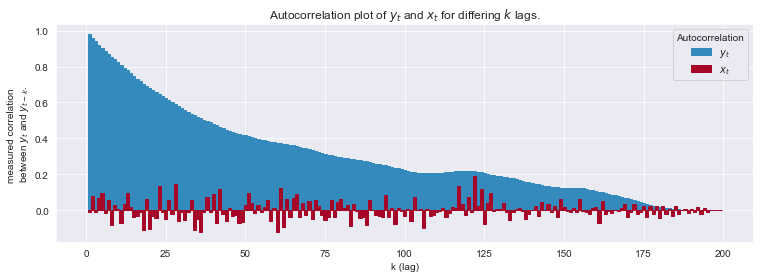

In [16]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

fig = plt.figure(figsize=(12.5, 4))

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");

In the above plot, we see that as we increase the lag, $k$, the autocorrelation for $y_t$ starts high and then tapers down to 0. On the other hand, the random nature of plot of $x_t$ indicates that it is not highly autocorrelated and that there is no pattern.

### Using autocorrelation to diagnose MCMC convergence

Since MCMC starts at a position and "walks" to a value near it, MCMC will always return a trace that is autocorrelated to a degree. A high autocorrelation value indicates that the chain is not exploring the data space very well. This means that a chain that is not highly autocorrelated is a sign that the chain has converged. This is not always the case however, since sometimes convergence can be achieved with an autocorrelated chain.

### A technique to reduce autocorrelation is to thin the data.

This is done by sampling every $n$th sample.

Another way to do this is to standardize the data by removing the data's mean and scale to a unit variance of 1.

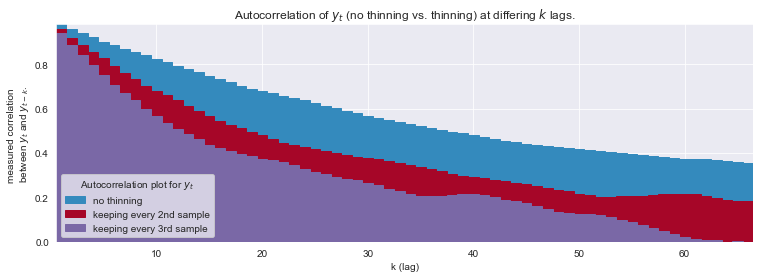

In [17]:
fig = plt.figure(figsize=(12.5, 4))

max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");

Increasing the number of values (usually below 10) between sampling means that autocorrelation will decrease faster, but the disadvantage is that we would need to sample more data to make up for the samples we didn't keep.

### Using pymc3.plots to do autocorrelation analysis

Fortunately, pymc3 has a plots module that does the autocorrelation without manually creating the graphs above.

C:\Users\moogl\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\moogl\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026B88F9FD68>,
      dtype=object)

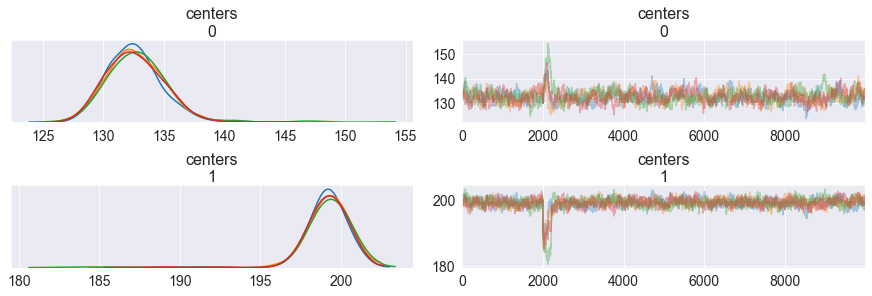

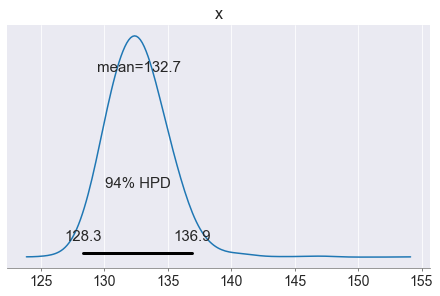

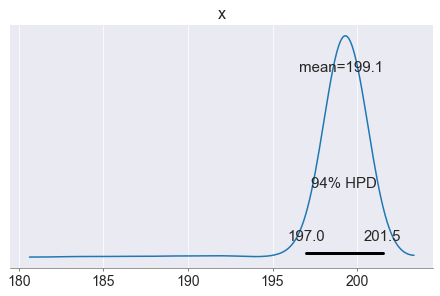

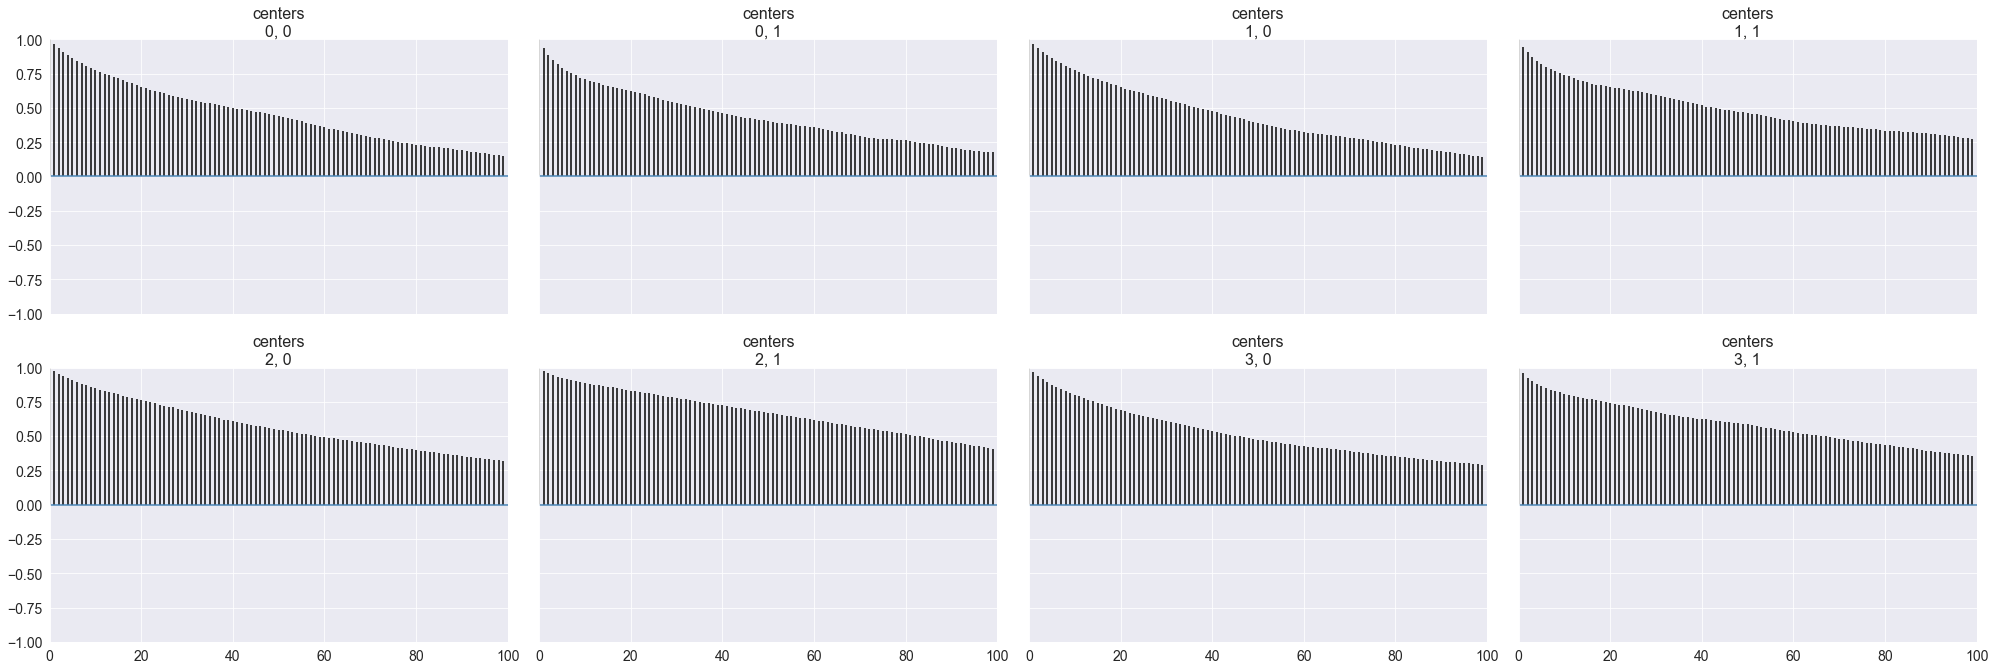

In [18]:
pm.plots.traceplot(data=trace, varnames=["centers"])
pm.plots.plot_posterior(data=trace["centers"][:,0])
pm.plots.plot_posterior(data=trace["centers"][:,1])
pm.plots.autocorrplot(data=trace, varnames=["centers"])

The posterior distribution and the trace plot is shown above near the top. Near the bottom we have the autocorrelation plots for both centers. What's new is the histogram plot of our samples. What you'll notice is the horizontal bar denoting the 95% HPD, which is the _highest priority density_ interval. This can also be interpretated as a 95% chance that the variable lies in this interval. The wider the bar, the higher the uncertainty. This interval is important for reporting purposes since we can be highly confident that the true value is within this.